# Setup

In [8]:
!pip install transformers
!pip install datasets
!pip install sentence_transformers
!pip install wordcloud
!git clone https://github.com/pan-webis-de/pan-code.git

#!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng
#!pip install latex
#!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.7 MB/s 
     |████████████████████████████████| 7.6 MB 39.1 MB/s 
     |████████████████████████████████| 182 kB 44.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 5.0 MB/s 
     |████████████████████████████████| 213 kB 51.5 MB/s 
     |████████████████████████████████| 132 kB 52.8 MB/s 
     |████████████████████████████████| 127 kB 60.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 1.3 MB 36.0 MB/s 
  Created wheel for senten

In [7]:
base_seed = 42

In [11]:
import os
import pandas as pd
import json
from pandas import json_normalize
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics.pairwise import cosine_distances
import sys

import torch

import os
sys.path.append(os.path.abspath("pan-code/clef22/style-change-detection/evaluator"))
from evaluator import *
from sentence_transformers import SentenceTransformer, InputExample, util, losses
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from typing import List
import random
import math




In [2]:
#!unzip pan22.zip


#  Data management

In [4]:
def create_dataframe(directory : str):
  """
  Read a set of individual files in the PAN original format from a directory and
  parse the result into a single dataframe
  """
  
  train_set = []
  for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      if f.endswith('.json'):
            train_set.append(f)

  train_set.sort(key=lambda f: int(re.sub('\D', '', f))) #sorting alphabetically files by name in order to have the correct order

  data = []
  for name in train_set:
    with open(name) as json_data:
      data_dict = json.load(json_data)
      data.append(data_dict)

  df = json_normalize(data)
  
  train_set_text = []
  for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      if f.endswith('.txt'):
            train_set_text.append(f)

  train_set_text.sort(key=lambda f: int(re.sub('\D', '', f)))

  text_list = []
  for file in train_set_text:
    with open(file) as f:
      content = f.read()
      text_list.append(content)

  df['input_text'] = text_list

  splitted_text = []
  for text in df['input_text']:
    split = text.splitlines()
    splitted_text.append(split)

  df['splitted_text'] = pd.Series(splitted_text)

  #Sanity check, checking if we have splitted correctly (according to the datset) the input text 
  for i in range(len(df.index)):
    if len(df['splitted_text'].iloc[i]) != len(df['paragraph-authors'].iloc[i]):
      print("we have a problem at row: ",i)
    
  return df

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# Utility functions

In [17]:
def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  
  # Pytorch
  torch.use_deterministic_algorithms(True)
  torch.manual_seed(seed)

In [ ]:
def create_contrastive_examples(documents : List[List[str]], authors : List[List[str]], tokenizer : AutoTokenizer, max_length : int, max_samples : int):
  """
  Build a contrastive dataset from a set of passages and the authors they were written by
  If the created dataset contains more samples than the max_samples parameter, discard the excess ones

  :param documents: The documents from which to sample examples
  :param authors: The author list for the relative documents 
  :param tokenizer: Model tokenizer
  :param max_length: Maximum length of the tokenization step
  :param max_samples: Maximum number of samples to return, if None no limit is set 
  """
  rows = []
  # Splitting data.
  for document, author in zip(documents, authors):
    if len(author) != len(document):
      continue
    for i in range(len(document)):
      for j in range(len(document)):
        if i != j:
          new_row = {}

          text1 = document[i][:sum([len(t) + 1 for t in tokenizer.tokenize(document[i])[:max_length]])]
          text2 = document[j][:sum([len(t) + 1 for t in tokenizer.tokenize(document[j])[:max_length]])]

          new_row["text1"] = text1
          new_row["text2"] = text2

          if author[i] != author[j]:
            new_row["label"] = 0 # 0 if different
          else:
            new_row["label"] = 1 # 1 if same

          rows.append(new_row)

  df = pd.DataFrame(rows, columns=['text1', 'text2', 'label'])

  # Sample the required positive and negative samples
  pos_samples = df[df["label"] == 1]
  neg_samples = df[df["label"] == 0]
  print(len(pos_samples))
  print(len(neg_samples))
  if len(pos_samples) > max_samples//2:
      pos_samples = pos_samples.sample(max_samples//2)
  if len(neg_samples) > max_samples//2:
      neg_samples = neg_samples.sample(max_samples//2)    

  df = pd.concat([pos_samples, neg_samples], axis=0, ignore_index=True).sample(frac=1)

  # From this create a dataset which can be handled by sentence-transformers
  train_examples = []
  for i, row in df.iterrows():
    train_examples.append(InputExample(texts=[row["text1"], row["text2"]], label=row["label"]))
  
  return np.array(train_examples)

In [ ]:
# Semi hard/hard negative mining
# Create triplet dataset
def create_triplet_examples(documents : List[List[str]], authors : List[List[str]], tokenizer : AutoTokenizer, max_length : int, n_per_document : int,
                            max_samples : int, model : SentenceTransformer, margin : float, mine_all=True, mine_hard=False, mine_semihard = False, is_task1 = False):
  """
  Build a triplet dataset from a set of passages and the authors they were written by
  If the created dataset contains more samples than the max_samples parameter, discard the excess ones
  :param documents: The documents from which to sample examples
  :param authors: The author list for the relative documents 
  :param tokenizer: Model tokenizer
  :param max_length: Maximum length of the tokenization step
  :param n_per_document: how many triplets to sample from each document at most
  :param max_samples: Maximum number of samples to return, if None no limit is set 
  :param model: Untrained model, used to check which examples are easy/hard/semi-hard 
  :param margin: Model margin
  :param mine_all: if true do not care about easy/hard examples and take all of them
  :param mine_hard: if true mine hard examples
  :param mine_semihard: if true mine semi-hard examples
  :param is_task1: set to true if the current task is task1, where we want to mine the change
  """
  rows = []
  rows_hard = []
  rows_shard = []
  # Splitting data.
  for document, author in zip(documents, authors):
    used_idxs = []
    n_remaining = n_per_document
    
    # Get the indexes of each author
    author_idxs = {}
    for index, value in enumerate(author):
      if value not in author_idxs:
          author_idxs[value] = []
      author_idxs[value].append(index)
    
    if is_task1:
      # Take the hard example (the change one)
      changes = [int(author[i] == author[i+1]) for i in range(len(author)-1)]
      change_idx = changes.index(0)

      try:
        a_idx = random.choice([x for x in author_idxs[author[change_idx]] if x != change_idx])
      except IndexError:
        continue
      pos_idx = change_idx
      neg_idx = change_idx+1

      new_row = {}

      new_row["anchor"] = document[a_idx][:sum([len(t) + 1 for t in tokenizer.tokenize(document[a_idx])[:max_length]])]
      new_row["pos"] = document[pos_idx][:sum([len(t) + 1 for t in tokenizer.tokenize(document[pos_idx])[:max_length]])]
      new_row["neg"] = document[neg_idx][:sum([len(t) + 1 for t in tokenizer.tokenize(document[neg_idx])[:max_length]])]

      rows_shard.append(new_row)
      used_idxs.append((a_idx, pos_idx, neg_idx))

      n_remaining -= 1
    else:
      if all([len(author_idxs[k])==1 for k in author_idxs]):
          continue

    # I could compute how many combinations are possible but it's too hard
    idx_errors = 0
    while n_remaining > 0:
      if idx_errors > 5:
        break
      try:
        # Sample a random author
        anchor_author = random.choice(list(author_idxs.keys()))

        # Get a paragraph from that author (anchor)
        a_idx = random.choice(author_idxs[anchor_author])

        # Get another paragraph from the same author
        pos_idx = random.choice([x for x in author_idxs[anchor_author] if x != a_idx])

        # Sample another author
        neg_author = random.choice([x for x in list(author_idxs.keys()) if x != anchor_author])

        # Get a paragraph from that author
        neg_idx = random.choice(author_idxs[neg_author])
      except IndexError:
        idx_errors += 1
        continue

      if (a_idx, pos_idx, neg_idx) in used_idxs:
        idx_errors += 1
        continue

      else:
        used_idxs.append((a_idx, pos_idx, neg_idx))
        new_row = {}

        new_row["anchor"] = document[a_idx][:sum([len(t) + 1 for t in tokenizer.tokenize(document[a_idx])[:max_length]])]
        new_row["pos"] = document[pos_idx][:sum([len(t) + 1 for t in tokenizer.tokenize(document[pos_idx])[:max_length]])]
        new_row["neg"] = document[neg_idx][:sum([len(t) + 1 for t in tokenizer.tokenize(document[neg_idx])[:max_length]])]

        if mine_hard or mine_semihard:
          # Compute embeddings
          a_embedding = model.encode([new_row["anchor"]], convert_to_tensor=True)
          p_embedding = model.encode([new_row["pos"]], convert_to_tensor=True)
          n_embedding = model.encode([new_row["neg"]], convert_to_tensor=True)

          # Compute distance between anchor and positive
          a_p_dist = 1 - util.cos_sim(a_embedding, p_embedding).cpu().item()
          # Compute distance between anchor and negative
          a_n_dist = 1 - util.cos_sim(a_embedding, n_embedding).cpu().item()

          if a_n_dist < a_p_dist:
            # Hard example
            if mine_hard:
              rows_hard.append(new_row)
          elif a_n_dist < a_p_dist + margin and a_n_dist > a_p_dist:
            # Semi hard example
            if mine_semihard:
              rows_shard.append(new_row)
          else:
            if mine_all:
              rows.append(new_row)
          n_remaining -= 1
        else:
          rows.append(new_row)
          n_remaining -= 1

  print(f"N easy:{len(rows)}, N hard: {len(rows_hard)}, N semihard:{len(rows_shard)}")
  random.shuffle(rows_shard)
  random.shuffle(rows_hard)
  random.shuffle(rows)

  all_rows = [*rows_shard, *rows_hard, *rows]
  if len(all_rows) < max_samples:
    all_rows = all_rows[:max_samples]
  print(len(all_rows))

  df = pd.DataFrame(all_rows, columns=['anchor', 'pos', 'neg'])

  # From this create a dataset which can be handled by sentence-transformers
  train_examples = []
  for i, row in df.iterrows():
    train_examples.append(InputExample(texts=[row["anchor"], row["pos"], row["neg"]]))
  
  return np.array(train_examples)

In [ ]:
def compute_same_diff_contrastive(model : SentenceTransformer, dataloader : DataLoader):
  """
  Function used on a contrastive dataset to evaluate model predictions wrt similarity
  Separates training samples in 2 groups, those which represent same-author examples and those which represent different-authors examples
  Returns two lists, one containing the computed similarities for the first set and one for the second set

  :param model: Trained model
  :param dataloader: Train dataloader
  """
  model = model.to(device)
  model.eval()
  same_sims = []
  diff_sims = []

  for idx, batch in enumerate(dataloader):
      author_info = batch[1]

      with torch.no_grad():
          text1 = {k:batch[0][0][k].to(device) for k in batch[0][0]}
          embeddings1 = model(text1)["sentence_embedding"]

          text2 = {k:batch[0][1][k].to(device) for k in batch[0][1]}
          embeddings2 = model(text2)["sentence_embedding"]
          
      
      for i in range(len(author_info)):
          same = author_info[i]
          sim = util.cos_sim(embeddings1[i], embeddings2[i]).cpu().item()
          if same == 1:
              same_sims.append(sim)
          else:
              diff_sims.append(sim)
  return same_sims, diff_sims

def compute_same_diff_triplet(model : SentenceTransformer, dataloader : DataLoader):
  """
  Function used on a triplet dataset to evaluate model predictions wrt similarity
  For each triplet example computes the similarity between the anchor and the positive and puts the result in set1, then computes
  the similarity between the anchor and the negative and puts the result in set2
  Returns two lists, one containing the computed similarities for the first set and one for the second set

  :param model: Trained model
  :param dataloader: Train dataloader
  """
  model.eval()
  same_sims = []
  diff_sims = []

  for idx, batch in enumerate(dataloader):
      with torch.no_grad():
          anchor = {k:batch[0][0][k].to(device) for k in batch[0][0]}
          embeddings_a = model(anchor)["sentence_embedding"]

          pos = {k:batch[0][1][k].to(device) for k in batch[0][1]}
          embeddings_p = model(pos)["sentence_embedding"]

          neg = {k:batch[0][2][k].to(device) for k in batch[0][2]}
          embeddings_n = model(neg)["sentence_embedding"]

      for i in range(anchor["input_ids"].shape[0]):

          sim_pos = util.cos_sim(embeddings_a[i], embeddings_p[i]).cpu().item()
          sim_neg = util.cos_sim(embeddings_a[i], embeddings_n[i]).cpu().item()

          same_sims.append(sim_pos)
          
          diff_sims.append(sim_neg)
  return same_sims, diff_sims

# Task 1



The first task. The objective is given a set of sentences to find the point where the author of those sentences change.
In task 1 there is only a single occurrence of this change

In [ ]:
train_directory = './dataset1/train'
df_train = create_dataframe(train_directory)
df_train.head()

valid_directory = './dataset1/validation'
df_valid = create_dataframe(valid_directory)
df_valid.head()

,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,2,serverfault.com.7z,1,"[0, 0, 1, 0, 0]","[1, 1, 1, 2, 2, 2]",If you can handle a slight delay in the data y...,[If you can handle a slight delay in the data ...
1,2,serverfault.com.7z,1,"[0, 1, 0, 0, 0, 0]","[1, 1, 2, 2, 2, 2, 2]",I figured i'd share my method which worked to ...,[I figured i'd share my method which worked to...
2,2,networkengineering.stackexchange.com.7z,1,"[1, 0, 0, 0]","[1, 2, 2, 2, 2]",This is not possible the way I want to impleme...,[This is not possible the way I want to implem...
3,2,serverfault.com.7z,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]",We have central HQ building and a lot of small...,[We have central HQ building and a lot of smal...
4,2,cstheory.stackexchange.com.7z,1,"[1, 0, 0]","[1, 2, 2, 2]",Moser's proof of the constructive Lovasz Local...,[Moser's proof of the constructive Lovasz Loca...


### Inference strategy
Given a SentenceTransformer model encoder and a set of sentences we predict where the change of author happens with the following approach:
- For each successive pair of passages compute their embeddings using the model
- Compute the cosine similarity between these embeddings, this is the similarity between the two passages according to our model
- Find the least similar successive passages, the change is set to happen there

In [ ]:
def prediction_task1(model : SentenceTransformer, sentences : List[str]):
  """
  Perform inference on a set of sentences
  """

  # Get metric embeddings
  embeddings = model.encode(sentences, convert_to_tensor=True)

  similarity_scores = []
  # For each successive embedding find their similarity
  for i in range(len(sentences)-1):
    sim = util.cos_sim(embeddings[i], embeddings[i+1])
    similarity_scores.append(sim.item()) 
  
  # Put the change at the position where similarity is lowest
  change_idx = np.argmin(similarity_scores)

  out_changes = np.zeros(len(similarity_scores))
  out_changes[change_idx] = 1
  return out_changes

# Evaluator function
def evaluate_mmodel_task1(model : SentenceTransformer, df : pd.DataFrame, save_pred_to_disk=None):
  """
  Evaluate a SentenceTransformer encoder model using the task1 inference method on a dataframe of examples
  """
  valid_labels = []
  y_preds = []

  for i, row in df.iterrows():
    sentences = row["splitted_text"]

    out_changes = prediction_task1(model, sentences)
    valid_labels += row["changes"]

    y_preds += list(out_changes)


  print(classification_report(valid_labels, y_preds))
  if not save_pred_to_disk is None:
    np.save(save_pred_to_disk, y_preds)


## Model 1 - Frozen SBERT


The first baseline model, where no training is performed and the inference strategy is used as is

In [ ]:
set_reproducibility(base_seed)
# Instantiate model
#model_type = "all-mpnet-base-v2"
model_type = 'AnnaWegmann/Style-Embedding'

model = SentenceTransformer(model_type)


In [ ]:
evaluate_mmodel_task1(model, df_valid)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1841
           1       0.48      0.48      0.48       300

    accuracy                           0.85      2141
   macro avg       0.70      0.70      0.70      2141
weighted avg       0.85      0.85      0.85      2141



## Model 2 - Trained SBERT with contrastive loss 


Second model, build a contrastive dataset and train the model using contrastive loss.  
A single sample of this dataset is a triplet composed of:
- a passage $x_1$
- a passage $x_2$
- An integer, either 0 or 1, in the first case the author of the two passages is the same, in the second case the two passages were written by different authors.

In [ ]:
set_reproducibility(base_seed)
# Instantiate model

#model_type = "all-mpnet-base-v2"
model_type = 'AnnaWegmann/Style-Embedding'

model = SentenceTransformer(model_type)

In [ ]:
max_length = 128
train_ds = create_contrastive_examples(df_train["splitted_text"].values, df_train["paragraph-authors"].values, model.tokenizer, max_length, max_samples = 20000)
print("Dataset size:", len(train_ds))

train_dl = DataLoader(train_ds,
                      shuffle=True,
                      batch_size=8,
                      collate_fn=model.smart_batching_collate)

# Define contrastive loss
contrastive_loss = losses.ContrastiveLoss(model=model, distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE, margin=0.6)
epochs = 2

# Train
model.fit(train_objectives=[(train_dl, contrastive_loss)],
                       epochs=epochs,
                       warmup_steps=math.ceil(len(train_dl) * epochs * 0.1),
                       optimizer_params={
                           'lr': 2e-5,
                       }
        )


62682
39578
Dataset size: 20000


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
evaluate_mmodel_task1(model, df_valid)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1841
           1       0.63      0.63      0.63       300

    accuracy                           0.90      2141
   macro avg       0.78      0.78      0.78      2141
weighted avg       0.90      0.90      0.90      2141



## Model 3 - Trained SBERT with triplet loss


Third model, build a dataset of triplets and train the model using triplet loss.
A single sample of this dataset is a triplet composed of:
- an anchor passage $x_a$, written by an author $A_1$
- a positive passage $x_p$, also written by $A_1$
- a negative passage $x_n$, written by another author $A_2$

In [ ]:
set_reproducibility(base_seed)

# Instantiate model

#model_type = "all-mpnet-base-v2"
model_type = 'AnnaWegmann/Style-Embedding'

model = SentenceTransformer(model_type)

In [ ]:
max_length = 128
train_ds = create_triplet_examples(df_train["splitted_text"].values, df_train["paragraph-authors"].values, model.tokenizer, 
                                   max_length, n_per_document=20, max_samples = 20000, model=model, margin=0.6, is_task1=True)
print("Dataset size:", len(train_ds))
train_dl = DataLoader(train_ds,
                      shuffle=True,
                      batch_size=8,
                      collate_fn=model.smart_batching_collate)

# Define triplet loss
triplet_loss = losses.TripletLoss(model=model, triplet_margin=0.6, distance_metric=losses.TripletDistanceMetric.COSINE)
epochs = 2

# Train
model.fit(train_objectives=[(train_dl, triplet_loss)],
                       epochs=epochs,
                       warmup_steps=math.ceil(len(train_dl) * epochs * 0.1),
                       optimizer_params={
                           'lr': 2e-5,
                       })

18493
Dataset size: 18493


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2312 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2312 [00:00<?, ?it/s]

In [ ]:
evaluate_mmodel_task1(model, df_valid)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1841
           1       0.62      0.62      0.62       300

    accuracy                           0.89      2141
   macro avg       0.78      0.78      0.78      2141
weighted avg       0.89      0.89      0.89      2141



## Model 4 - Trained SBERT with triplet loss, hard/semi hard negative mining


Fourth model, like model 3 but use only hard and semi hard triplet examples.  
If the margin hyperparameter is $\alpha$, our encoder model is $M$ we say that a triplet $(x_a,x_p, x_n)$ is:
- Hard: if $cos\_dist(M(x_a),M(x_n)) < cos\_dist(M(x_a), M(x_p))$
- Semi hard: if $cos\_dist(M(x_a), M(x_p)) < cos\_dist(M(x_a), M(x_n))$ but $cos\_dist(M(x_n), M(x_p)) < \alpha$
- Easy: otherwise

In [ ]:
set_reproducibility(base_seed)
# Instantiate model

#model_type = "all-mpnet-base-v2"
model_type = 'AnnaWegmann/Style-Embedding'

model = SentenceTransformer(model_type)

In [ ]:
max_length = 128

# Define triplet loss
triplet_loss = losses.TripletLoss(model=model, triplet_margin=0.6, distance_metric=losses.TripletDistanceMetric.COSINE)

model.eval()
train_ds = create_triplet_examples(df_train["splitted_text"].values, df_train["paragraph-authors"].values, model.tokenizer, 
                                            max_length, n_per_document=10, max_samples = 20000, model=model, margin=0.6, 
                                 mine_all=False, mine_semihard=True, mine_hard=True)
train_dl = DataLoader(train_ds,
                  shuffle=True,
                  batch_size=8,
                  collate_fn=model.smart_batching_collate)

epochs = 3
model.train()
# Train
model.fit(train_objectives=[(train_dl, triplet_loss)],
                       epochs=epochs,
                       warmup_steps=math.ceil(len(train_dl) * epochs * 0.1),
                       optimizer_params={
                           'lr': 2e-5,
                       })

N easy:0, N hard: 3402, N semihard:5365
8767


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1096 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1096 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1096 [00:00<?, ?it/s]

In [ ]:
evaluate_mmodel_task1(model, df_valid)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1841
           1       0.65      0.65      0.65       300

    accuracy                           0.90      2141
   macro avg       0.80      0.80      0.80      2141
weighted avg       0.90      0.90      0.90      2141



# Task 2


The second task. The objective is given a set of sentences assign each of them to a label corresponding to the author that wrote it.
Multiple changes between authors can occurr and in a set of sentences there can be up to 5 authors.

In [13]:
train_directory = './dataset2/train'
df_train = create_dataframe(train_directory)
df_train.head()

,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,3,serverfault.com.7z,1,"[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1]","[1, 2, 3, 2, 1, 2, 2, 1, 3, 3, 1, 1, 3]",Small Business Server (SBS) would seem to be a...,[Small Business Server (SBS) would seem to be ...
1,5,serverfault.com.7z,1,"[1, 1, 1, 1, 1, 1]","[1, 2, 3, 4, 5, 2, 3]",None of the suggested key combinations bring m...,[None of the suggested key combinations bring ...
2,5,superuser.com.7z,1,"[1, 0, 1, 1, 0, 1, 1, 1]","[1, 2, 2, 3, 2, 2, 4, 3, 5]","If you are using the ext3 filesystem, then ext...","[If you are using the ext3 filesystem, then ex..."
3,3,serverfault.com.7z,1,"[1, 1, 1, 0, 1]","[1, 2, 3, 1, 1, 2]","The sites are backed by a WCMS, so there is a ...","[The sites are backed by a WCMS, so there is a..."
4,1,serverfault.com.7z,0,"[0, 0, 0]","[1, 1, 1, 1]",I had a similar problem. I needed to delete a ...,[I had a similar problem. I needed to delete a...


In [14]:
valid_directory = './dataset2/validation'
df_valid = create_dataframe(valid_directory)
df_valid.head()

,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,5,serverfault.com.7z,1,"[1, 0, 1, 1, 1]","[1, 2, 2, 3, 4, 5]",Force detach the system volume. Then you will...,[Force detach the system volume. Then you wil...
1,5,serverfault.com.7z,1,"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 2, 3, 1, 4, 1, 4, 5, 4]","At any rate, I suspect that these applications...","[At any rate, I suspect that these application..."
2,1,serverfault.com.7z,0,"[0, 0]","[1, 1, 1]",I'm trying to understand the hype around cloud...,[I'm trying to understand the hype around clou...
3,1,cstheory.stackexchange.com.7z,0,[0],"[1, 1]","I think one issue is that we need to fix the ""...",[I think one issue is that we need to fix the ...
4,4,gamedev.stackexchange.com.7z,1,"[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]","[1, 2, 3, 1, 1, 1, 1, 3, 1, 3, 3, 2, 4, 2, 2, 1]",Keep in mind that AI/effects that happen on a ...,[Keep in mind that AI/effects that happen on a...


### Inference strategy
Given a SentenceTransformer model encoder and a set of sentences we assign each of them to an author using 2 different methods. 

The first one is threshold based and works as follows:
- start from the first passage, for each of them
compare its similarity with all the previous
passages.
- apply the threshold to all of them to detect
pairwise changes, if we notice that we detect
a style change for all of them this means that
we have a new cluster. In case we already have
5 clusters (the maximum number of different
authors in a conversation) even if we detect
a change assign it to the cluster of the most
similar other passage
- If after thresholding we detect that there is no
style change between said passage and any
one of them, assign this passage to the same
cluster as the one from which the most similar
passage came from

The second one is based on using the pairwise distances as a precomputed distance matrix which we can feed into a clustering algorithm like DBSCAN.

The threshold is computed in two ways:
- Fixed threshold, use the margin as threshold
- Learned threshold,  after training we can apply our model to
the contrastive pairs and measure the average similarity for same-author samples and
different-author samples, the threshold should
lie between these two averages. If we define the same-author set of similarities as $S_1$, the different-author set of similarities as $S_2$ we compute the threshold as: $\frac{(\mu(S_1)-2\sigma(S_1)) + (\mu(S_2)+2\sigma(S_2))}{2}$

In [ ]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics.pairwise import cosine_distances

def prediction_task2_threshold(model : SentenceTransformer, sentences : List[str], threshold : float):
  """
  Perform inference on a set of sentences using the threshold approach
  """
  embeddings = model.encode(sentences, convert_to_tensor=True)

  pred_authors = [1]
  for i in range(1, len(sentences)):
    similarity_scores = []
    for j in range(i):
        sim = util.cos_sim(embeddings[i], embeddings[j])
        similarity_scores.append(sim.item()) 
    changes = [s > threshold for s in similarity_scores]
    
    if all(x == 0 for x in changes):
        # New author
        new_auth = max(pred_authors)+1
        if new_auth > 5:
            most_similar = pred_authors[np.argmax(similarity_scores)]
            pred_authors.append(most_similar)
        else:
            pred_authors.append(new_auth)
    else:
        # Find most similar
        most_similar = pred_authors[np.argmax(similarity_scores)]
        pred_authors.append(most_similar)
  return pred_authors

def prediction_task2_unsupervised(model : SentenceTransformer, sentences : List[str]):
  """
  Perform inference on a set of sentences using the unsupervised clustering approach
  """
  embeddings = model.encode(sentences, convert_to_tensor=False)

  # Compute all pairwise cosine similarities
  sim = cosine_distances(embeddings, embeddings)
  
  documents = np.arange(len(embeddings)).reshape(-1,1)
  clustered = DBSCAN(metric="precomputed", eps=0.5, min_samples=1).fit(sim)
  #clustered = AgglomerativeClustering(affinity="precomputed", n_clusters=row["authors"], linkage="average").fit(sim)
  
  y_pred = [x for x in clustered.labels_]
  y_pred_constr = []
  
  for idx1, el1 in enumerate(y_pred):
    if el1 < 5:
      y_pred_constr.append(el1+1)
    else:
      distance_dict = {}
      for idx2, el2 in enumerate(y_pred):
        if el2 >= 5 or idx1 == idx2:
          continue
        if el2 not in distance_dict:
          distance_dict[el2] = [sim[idx1,idx2]]
        else:
          distance_dict[el2].append(sim[idx1,idx2])
        
      distance_dict = {k:np.mean(distance_dict[k]) for k in distance_dict}
      new_label = min(distance_dict, key=distance_dict.get)
      y_pred_constr.append(new_label+1)
        
  return y_pred_constr
    
def evaluate_mmodel_task2(model : SentenceTransformer, df : pd.DataFrame, threshold : float, save_pred_to_disk : str =None):
  """
  Evaluate a SentenceTransformer encoder model using one of the two task2 inference method on a dataframe of examples
  """
  valid_labels = []
  y_preds = []

  for i, row in df.iterrows():
    sentences = row["splitted_text"]
    
    if threshold is None:
      pred_authors = prediction_task2_unsupervised(model, sentences)
    else:
      pred_authors = prediction_task2_threshold(model, sentences, threshold)

    valid_labels += row["paragraph-authors"]
    y_preds += pred_authors

  print(classification_report(valid_labels, y_preds))
  if not save_pred_to_disk is None:
    np.save(save_pred_to_disk, y_preds)

## Model 1 - Frozen SBERT

The first baseline model, where no training is performed and the inference strategy is used as is.

In [ ]:
set_reproducibility(base_seed)

#model_type = "all-mpnet-base-v2"
model_type = 'AnnaWegmann/Style-Embedding'

model = SentenceTransformer(model_type)

In [ ]:
# Create a training DS just to calibrate the threshold
max_length = 128
train_ds = create_contrastive_examples(df_train["splitted_text"].values, df_train["paragraph-authors"].values, model.tokenizer, 
                                       max_length, max_samples = 50000)
print("Dataset size:", len(train_ds))
train_dl = DataLoader(train_ds,
                      shuffle=True,
                      batch_size=8,
                      collate_fn=model.smart_batching_collate)

model.eval()
# Compute the threshold
same_sims, diff_sims = compute_same_diff_contrastive(model, train_dl)
th = np.mean([np.mean(same_sims)-2*np.std(same_sims), np.mean(diff_sims)+2*np.std(diff_sims)])

print(f"Using {th} as threshold")
evaluate_mmodel_task2(model, df_valid, th, save_pred_to_disk="task2_model1_style.npy")

print(f"Unsupervised clustering")
evaluate_mmodel_task2(model, df_valid, None)

154108
272236
Dataset size: 50000
Using 0.43099294799502624 as threshold
              precision    recall  f1-score   support

           1       0.64      0.77      0.70      5098
           2       0.44      0.49      0.46      2828
           3       0.33      0.26      0.29      1701
           4       0.29      0.11      0.16       978
           5       0.16      0.03      0.04       432

    accuracy                           0.53     11037
   macro avg       0.37      0.33      0.33     11037
weighted avg       0.49      0.53      0.50     11037

Unsupervised clustering
              precision    recall  f1-score   support

           1       0.59      0.83      0.69      5098
           2       0.44      0.39      0.41      2828
           3       0.32      0.19      0.24      1701
           4       0.29      0.10      0.14       978
           5       0.15      0.03      0.05       432

    accuracy                           0.52     11037
   macro avg       0.36      0.31 

## Model 2 - Trained SBERT with contrastive loss

Second model, build a contrastive dataset and train the model using contrastive loss.  


In [ ]:
set_reproducibility(base_seed)

#model_type = "all-mpnet-base-v2"
model_type = 'AnnaWegmann/Style-Embedding'

model = SentenceTransformer(model_type)

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/117 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/659 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/354 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
max_length = 128
train_ds = create_contrastive_examples(df_train["splitted_text"].values, df_train["paragraph-authors"].values, model.tokenizer, 
                                       max_length, max_samples = 50000)
print("Dataset size:", len(train_ds))
train_dl = DataLoader(train_ds,
                      shuffle=True,
                      batch_size=8,
                      collate_fn=model.smart_batching_collate)

# Define contrastive loss
contrastive_loss = losses.ContrastiveLoss(model=model, distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE, margin=0.6)
epochs = 2

# Train
model.fit(train_objectives=[(train_dl, contrastive_loss)],
                       epochs=epochs,
                       warmup_steps=math.ceil(len(train_dl) * epochs * 0.1),
                       optimizer_params={
                           'lr': 2e-5,
                       }
        )

154108
272236
Dataset size: 50000


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6250 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6250 [00:00<?, ?it/s]

In [ ]:
model.eval()
# Compute the threshold
same_sims, diff_sims = compute_same_diff_contrastive(model, train_dl)
th = np.mean([np.mean(same_sims)-2*np.std(same_sims), np.mean(diff_sims)+2*np.std(diff_sims)])

print(f"Using {th} as threshold")
evaluate_mmodel_task2(model, df_valid, th, save_pred_to_disk="task2_model2_style.npy")

th = 0.6

print(f"Using margin({th}) as threshold")
evaluate_mmodel_task2(model, df_valid, th)

print(f"Unsupervised clustering")
evaluate_mmodel_task2(model, df_valid, None)

Using 0.7385238137675535 as threshold
              precision    recall  f1-score   support

           1       0.74      0.78      0.76      5098
           2       0.56      0.59      0.57      2828
           3       0.40      0.39      0.40      1701
           4       0.33      0.25      0.29       978
           5       0.24      0.17      0.20       432

    accuracy                           0.60     11037
   macro avg       0.45      0.44      0.44     11037
weighted avg       0.59      0.60      0.59     11037

Using margin(0.6) as threshold
              precision    recall  f1-score   support

           1       0.62      0.91      0.74      5098
           2       0.52      0.49      0.51      2828
           3       0.43      0.19      0.26      1701
           4       0.39      0.04      0.08       978
           5       0.43      0.01      0.01       432

    accuracy                           0.58     11037
   macro avg       0.48      0.33      0.32     11037
weighted

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 3 - Trained SBERT with triplet loss

Third model, build a dataset of triplets and train the model using triplet loss.


In [ ]:
set_reproducibility(base_seed)

#model_type = "all-mpnet-base-v2"
model_type = 'AnnaWegmann/Style-Embedding'

model = SentenceTransformer(model_type)

In [ ]:
max_length = 128
train_ds = create_triplet_examples(df_train["splitted_text"].values, df_train["paragraph-authors"].values, model.tokenizer, 
                                            max_length, n_per_document=20, max_samples = 50000, model=model, margin=0.6)
train_dl = DataLoader(train_ds,
                      shuffle=True,
                      batch_size=8,
                      collate_fn=model.smart_batching_collate)

# Define triplet loss
triplet_loss = losses.TripletLoss(model=model, triplet_margin=0.6, distance_metric=losses.TripletDistanceMetric.COSINE)
epochs = 2

# Train
model.fit(train_objectives=[(train_dl, triplet_loss)],
                       epochs=epochs,
                       warmup_steps=math.ceil(len(train_dl) * epochs * 0.1),
                       optimizer_params={
                           'lr': 2e-5,
                       })

N easy:49349, N hard: 0, N semihard:0
49349


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6169 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6169 [00:00<?, ?it/s]

In [ ]:
model.eval()

# Compute the threshold
same_sims, diff_sims = compute_same_diff_triplet(model, train_dl)
th = np.mean([np.mean(same_sims)-2*np.std(same_sims), np.mean(diff_sims)+2*np.std(diff_sims)])
#th = 0.6

print(f"Using {th} as threshold")
evaluate_mmodel_task2(model, df_valid, th, save_pred_to_disk="task2_model3_style.npy")

th = 0.6

print(f"Using margin({th}) as threshold")
evaluate_mmodel_task2(model, df_valid, th)

print(f"Unsupervised clustering")
evaluate_mmodel_task2(model, df_valid, None)

Using 0.37117809966651494 as threshold
              precision    recall  f1-score   support

           1       0.70      0.79      0.74      5098
           2       0.53      0.60      0.56      2828
           3       0.37      0.32      0.35      1701
           4       0.31      0.16      0.21       978
           5       0.19      0.05      0.08       432

    accuracy                           0.58     11037
   macro avg       0.42      0.38      0.39     11037
weighted avg       0.55      0.58      0.56     11037

Using margin(0.6) as threshold
              precision    recall  f1-score   support

           1       0.78      0.66      0.72      5098
           2       0.53      0.55      0.54      2828
           3       0.36      0.41      0.38      1701
           4       0.26      0.30      0.28       978
           5       0.15      0.24      0.19       432

    accuracy                           0.55     11037
   macro avg       0.42      0.43      0.42     11037
weighte

## Model 4 - Trained SBERT with triplet loss, hard/semi hard negative mining


Fourth model, like model 3 but use only hard and semi hard triplet examples.  


In [ ]:
set_reproducibility(base_seed)

#model_type = "all-mpnet-base-v2"
model_type = 'AnnaWegmann/Style-Embedding'

model = SentenceTransformer(model_type)

In [ ]:
max_length = 128

# Define triplet loss
triplet_loss = losses.TripletLoss(model=model, triplet_margin=0.6, distance_metric=losses.TripletDistanceMetric.COSINE)
model.eval()
train_ds = create_triplet_examples(df_train["splitted_text"].values, df_train["paragraph-authors"].values, model.tokenizer, 
                                            max_length, n_per_document=10, max_samples = 50000, model=model, margin=0.6, 
                                 mine_all=False, mine_semihard=True, mine_hard=True)
train_dl = DataLoader(train_ds,
                  shuffle=True,
                  batch_size=8,
                  collate_fn=model.smart_batching_collate)

epochs = 3
model.train()
# Train
model.fit(train_objectives=[(train_dl, triplet_loss)],
                       epochs=epochs,
                       warmup_steps=math.ceil(len(train_dl) * epochs * 0.1),
                       optimizer_params={
                           'lr': 2e-5,
                       })

N easy:0, N hard: 9773, N semihard:16076
25849


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3232 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3232 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3232 [00:00<?, ?it/s]

In [ ]:
model.eval()
same_sims, diff_sims = compute_same_diff_triplet(model, train_dl)
th = np.mean([np.mean(same_sims)-2*np.std(same_sims), np.mean(diff_sims)+2*np.std(diff_sims)])

print(f"Using {th} as threshold")
evaluate_mmodel_task2(model, df_valid, th, save_pred_to_disk="task2_model4_style.npy")

th = 0.6

print(f"Using margin({th}) as threshold")
evaluate_mmodel_task2(model, df_valid, th)

print(f"Unsupervised clustering")
evaluate_mmodel_task2(model, df_valid, None)

Using 0.3 as threshold
              precision    recall  f1-score   support

           1       0.68      0.79      0.73      5098
           2       0.51      0.59      0.55      2828
           3       0.36      0.29      0.32      1701
           4       0.24      0.09      0.13       978
           5       0.33      0.04      0.07       432

    accuracy                           0.57     11037
   macro avg       0.42      0.36      0.36     11037
weighted avg       0.53      0.57      0.54     11037

Using margin(0.6) as threshold
              precision    recall  f1-score   support

           1       0.79      0.61      0.69      5098
           2       0.53      0.54      0.53      2828
           3       0.35      0.41      0.38      1701
           4       0.22      0.31      0.25       978
           5       0.13      0.25      0.17       432

    accuracy                           0.52     11037
   macro avg       0.40      0.42      0.41     11037
weighted avg       0.58

# Task 3

The third task. The objective is given a set of sentences detect between which of them an author change occurs.
Multiple changes between authors can occur and in a set of sentences there can be up to 5 authors.

In [15]:
train_directory = './dataset3/train'
df_train = create_dataframe(train_directory)
df_train.head()

we have a problem at row:  1194


,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,5,serverfault.com.7z,1,"[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]","[1, 2, 1, 1, 3, 2, 2, 3, 4, 5, 5, 2]",Everything else equals I would say it being mo...,[Everything else equals I would say it being m...
1,1,gamedev.stackexchange.com.7z,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",I also apologize for the lack of a 'decent' ti...,[I also apologize for the lack of a 'decent' t...
2,5,superuser.com.7z,1,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1]","[1, 2, 3, 1, 1, 4, 5, 5, 1, 3, 3, 2, 2, 2, 1]",And updates should not need to touch /home/ an...,[And updates should not need to touch /home/ a...
3,1,computergraphics.stackexchange.com.7z,0,"[0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1]","But v1,v2,v4 and v5 would have non-zero normal...","[But v1,v2,v4 and v5 would have non-zero norma..."
4,3,superuser.com.7z,1,"[1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, ...","[1, 2, 1, 3, 2, 2, 3, 3, 2, 2, 1, 2, 2, 2, 3, ...",Now run this command to stop Windows from inst...,[Now run this command to stop Windows from ins...


In [16]:
valid_directory = './dataset3/validation'
df_valid = create_dataframe(valid_directory)
df_valid.head()

,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,4,serverfault.com.7z,1,"[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]","[1, 2, 1, 3, 3, 3, 1, 3, 4, 4, 1, 2, 3, 1, 1, 4]",And here is the question: why do I have to use...,[And here is the question: why do I have to us...
1,2,superuser.com.7z,1,"[1, 1, 1, 0, 0, 1, 0]","[1, 2, 1, 2, 2, 2, 1, 1]",Remove the Day column and combine the Date and...,[Remove the Day column and combine the Date an...
2,3,superuser.com.7z,1,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, ...","(I will use the ""&"" to execute the command in ...","[(I will use the ""&"" to execute the command in..."
3,2,superuser.com.7z,1,"[1, 0, 0, 0, 1, 1, 0]","[1, 2, 2, 2, 2, 1, 2, 2]",In the advanced settings of openvpn i have cho...,[In the advanced settings of openvpn i have ch...
4,4,superuser.com.7z,1,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, ...","[1, 1, 2, 1, 3, 4, 1, 2, 3, 1, 1, 2, 1, 3, 1, ...",Every single device does not exceed the limit ...,[Every single device does not exceed the limit...


### Inference strategy
Given a SentenceTransformer model encoder and a set of sentences we detect where an author change happens as follows:
- For each pair of consecutive passages obtain an embedding for both of them
- Compute the cosine similarity between the two embeddings
- Apply a threshold , below which we say that the two phrases are written by different authors


The threshold is computed in two ways:
- Fixed threshold, use the margin as threshold
- Learned threshold,  after training we can apply our model to
the contrastive pairs and measure the average similarity for same-author samples and
different-author samples, the threshold should
lie between these two averages. If we define the same-author set of similarities as $S_1$, the different-author set of similarities as $S_2$ we compute the threshold as: $\frac{(\mu(S_1)-2\sigma(S_1)) + (\mu(S_2)+2\sigma(S_2))}{2}$

In [ ]:
def prediction_task3_threshold(model : SentenceTransformer, sentences : List[str], threshold : float):
  """
  Perform inference on a set of sentences using the threshold approach
  """
  embeddings = model.encode(sentences, convert_to_tensor=True)

  similarity_scores = []

  for i in range(len(sentences)-1):
    sim = util.cos_sim(embeddings[i], embeddings[i+1])
    similarity_scores.append(sim.item()) 
  
  # Threshold
  pred_changes = [1 if sim < th else 0 for sim in similarity_scores]
  return pred_changes
    
def evaluate_mmodel_task3(model : SentenceTransformer, df : pd.DataFrame, threshold : float, save_pred_to_disk : str = None):
  """
  Evaluate a SentenceTransformer encoder model using the task3 inference method on a dataframe of examples
  """
  valid_labels = []
  y_preds = []

  for i, row in df.iterrows():
    sentences = row["splitted_text"]
    
    pred_authors = prediction_task3_threshold(model, sentences, threshold)

    valid_labels += row["changes"]
    y_preds += pred_authors

  print(classification_report(valid_labels, y_preds))
  if not save_pred_to_disk is None:
    np.save(save_pred_to_disk, y_preds)

## Model 1 - Frozen SBERT

The first baseline model, where no training is performed and the inference strategy is used as is

In [ ]:
set_reproducibility(base_seed)

#model_type = "all-mpnet-base-v2"
model_type = 'AnnaWegmann/Style-Embedding'

model = SentenceTransformer(model_type)

In [ ]:
# Create a training DS just to calibrate the threshold
max_length = 32
train_ds = create_contrastive_examples(df_train["splitted_text"].values, df_train["paragraph-authors"].values, model.tokenizer,
                                       max_length, max_samples = 500000)
print("Dataset size:", len(train_ds))
train_dl = DataLoader(train_ds,
                      shuffle=True,
                      batch_size=8,
                      collate_fn=model.smart_batching_collate)

model.eval()
# Compute the threshold
same_sims, diff_sims = compute_same_diff_contrastive(model, train_dl)
th = np.mean([np.mean(same_sims)-2*np.std(same_sims), np.mean(diff_sims)+2*np.std(diff_sims)])

print(f"Using {th} as threshold")
evaluate_mmodel_task3(model, df_valid, th, save_pred_to_disk="task3_model1_style.npy")


928658
1186486
Dataset size: 500000
Using 0.3619453541844835 as threshold
              precision    recall  f1-score   support

           0       0.53      0.65      0.59     10043
           1       0.64      0.53      0.58     12062

    accuracy                           0.58     22105
   macro avg       0.59      0.59      0.58     22105
weighted avg       0.59      0.58      0.58     22105



## Model 2 - Trained SBERT with contrastive loss

Second model, build a contrastive dataset and train the model using contrastive loss.  


In [ ]:
set_reproducibility(base_seed)

#model_type = "all-mpnet-base-v2"
model_type = 'AnnaWegmann/Style-Embedding'

model = SentenceTransformer(model_type)

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/117 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/659 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/354 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
max_length = 32
train_ds = create_contrastive_examples(df_train["splitted_text"].values, df_train["paragraph-authors"].values, model.tokenizer, 
                                       max_length, max_samples = 100000)
print("Dataset size:", len(train_ds))
train_dl = DataLoader(train_ds,
                      shuffle=True,
                      batch_size=8,
                      collate_fn=model.smart_batching_collate)

# Define contrastive loss
contrastive_loss = losses.ContrastiveLoss(model=model, distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE, margin=0.6)
epochs = 2

# Train
model.fit(train_objectives=[(train_dl, contrastive_loss)],
                       epochs=epochs,
                       warmup_steps=math.ceil(len(train_dl) * epochs * 0.1),
                       optimizer_params={
                           'lr': 2e-5,
                       }
        )

928658
1186486
Dataset size: 100000


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/12500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/12500 [00:00<?, ?it/s]

In [ ]:
model.eval()
# Compute the threshold
same_sims, diff_sims = compute_same_diff_contrastive(model, train_dl)
th = np.mean([np.mean(same_sims)-2*np.std(same_sims), np.mean(diff_sims)+2*np.std(diff_sims)])

print(f"Using {th} as threshold")
evaluate_mmodel_task3(model, df_valid, th, save_pred_to_disk="task3_model2_style.npy")

th = 0.6

print(f"Using margin({th}) as threshold")
evaluate_mmodel_task3(model, df_valid, th)


Using 0.6878071384977197 as threshold
              precision    recall  f1-score   support

           0       0.65      0.63      0.64     10043
           1       0.70      0.71      0.71     12062

    accuracy                           0.68     22105
   macro avg       0.67      0.67      0.67     22105
weighted avg       0.68      0.68      0.68     22105

Using margin(0.6) as threshold
              precision    recall  f1-score   support

           0       0.58      0.81      0.68     10043
           1       0.76      0.51      0.61     12062

    accuracy                           0.65     22105
   macro avg       0.67      0.66      0.64     22105
weighted avg       0.68      0.65      0.64     22105



## Model 3 - Trained SBERT with triplet loss

Third model, build a dataset of triplets and train the model using triplet loss.


In [ ]:
set_reproducibility(base_seed)

#model_type = "all-mpnet-base-v2"
model_type = 'AnnaWegmann/Style-Embedding'

model = SentenceTransformer(model_type)

In [ ]:
max_length = 32
train_ds = create_triplet_examples(df_train["splitted_text"].values, df_train["paragraph-authors"].values, model.tokenizer, 
                                            max_length, n_per_document=20, max_samples = 100000, model=model, margin=0.6)
train_dl = DataLoader(train_ds,
                      shuffle=True,
                      batch_size=8,
                      collate_fn=model.smart_batching_collate)

# Define triplet loss
triplet_loss = losses.TripletLoss(model=model, triplet_margin=0.6, distance_metric=losses.TripletDistanceMetric.COSINE)
epochs = 2

# Train
model.fit(train_objectives=[(train_dl, triplet_loss)],
                       epochs=epochs,
                       warmup_steps=math.ceil(len(train_dl) * epochs * 0.1),
                       optimizer_params={
                           'lr': 2e-5,
                       })

N easy:96005, N hard: 0, N semihard:0
96005


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/12001 [00:00<?, ?it/s]

Iteration:   0%|          | 0/12001 [00:00<?, ?it/s]

In [ ]:
model.eval()

# Compute the threshold
same_sims, diff_sims = compute_same_diff_triplet(model, train_dl)
th = np.mean([np.mean(same_sims)-2*np.std(same_sims), np.mean(diff_sims)+2*np.std(diff_sims)])

print(f"Using {th} as threshold")
evaluate_mmodel_task3(model, df_valid, th, save_pred_to_disk="task3_model3_style.npy")

th = 0.6

print(f"Using margin({th}) as threshold")
evaluate_mmodel_task3(model, df_valid, th)


Using 0.2701155882739125 as threshold
              precision    recall  f1-score   support

           0       0.62      0.63      0.63     10043
           1       0.69      0.68      0.68     12062

    accuracy                           0.66     22105
   macro avg       0.66      0.66      0.66     22105
weighted avg       0.66      0.66      0.66     22105

Using margin(0.6) as threshold
              precision    recall  f1-score   support

           0       0.71      0.37      0.48     10043
           1       0.62      0.88      0.73     12062

    accuracy                           0.64     22105
   macro avg       0.67      0.62      0.61     22105
weighted avg       0.66      0.64      0.62     22105



## Model 4 - Trained SBERT with triplet loss, hard/semi hard negative mining


Fourth model, like model 3 but use only hard and semi hard triplet examples.  


In [ ]:
set_reproducibility(base_seed)

#model_type = "all-mpnet-base-v2"
model_type = 'AnnaWegmann/Style-Embedding'

model = SentenceTransformer(model_type)

In [ ]:
max_length = 32

# Define triplet loss
triplet_loss = losses.TripletLoss(model=model, triplet_margin=0.6, distance_metric=losses.TripletDistanceMetric.COSINE)

train_ds = create_triplet_examples(df_train["splitted_text"].values, df_train["paragraph-authors"].values, model.tokenizer, 
                                            max_length, n_per_document=10, max_samples = 100000, model=model, margin=0.6, 
                                 mine_all=False, mine_semihard=True, mine_hard=True)
train_dl = DataLoader(train_ds,
                  shuffle=True,
                  batch_size=16,
                  collate_fn=model.smart_batching_collate)

epochs = 3

# Train
model.fit(train_objectives=[(train_dl, triplet_loss)],
                       epochs=epochs,
                       warmup_steps=math.ceil(len(train_dl) * epochs * 0.1),
                       optimizer_params={
                           'lr': 2e-5,
                       })

N easy:0, N hard: 20598, N semihard:24095
44693


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5587 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5587 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5587 [00:00<?, ?it/s]

In [ ]:
model.eval()
same_sims, diff_sims = compute_same_diff_triplet(model, train_dl)
th = np.mean([np.mean(same_sims)-2*np.std(same_sims), np.mean(diff_sims)+2*np.std(diff_sims)])
#th = 0.6

print(f"Using {th} as threshold")
evaluate_mmodel_task3(model, df_valid, th, save_pred_to_disk="task3_model4_style.npy")

th = 0.6

print(f"Using margin({th}) as threshold")
evaluate_mmodel_task3(model, df_valid, th)

Using 0.23284846905517453 as threshold
              precision    recall  f1-score   support

           0       0.60      0.62      0.61     10043
           1       0.68      0.66      0.67     12062

    accuracy                           0.64     22105
   macro avg       0.64      0.64      0.64     22105
weighted avg       0.64      0.64      0.64     22105

Using margin(0.6) as threshold
              precision    recall  f1-score   support

           0       0.71      0.33      0.45     10043
           1       0.61      0.89      0.73     12062

    accuracy                           0.63     22105
   macro avg       0.66      0.61      0.59     22105
weighted avg       0.66      0.63      0.60     22105



# Error Analysis

A simple error analysis that we can perform is analyzing how the model performance changes depending on the number of authors a set of passages has.  
This can be applied both to task 2 and 3.

In [ ]:
# Computes scores wrt to number of authors.
def compute_score_wrt_authors(task, pred, true, df):

  # Scores.
  f1 = []

  # Sublists of pred and true.
  where_n_authors_equal_1_pred = []
  where_n_authors_equal_1_true = []
  where_n_authors_equal_2_pred = []
  where_n_authors_equal_2_true = []
  where_n_authors_equal_3_pred = []
  where_n_authors_equal_3_true = []
  where_n_authors_equal_4_pred = []
  where_n_authors_equal_4_true = []
  where_n_authors_equal_5_pred = []
  where_n_authors_equal_5_true = []

  # Variable used to index pred and true.
  i = 0
  
  # Checking task.
  if task == 2:
    
    # Fetching portions of pred where #authors = 1, 2, 3, 4 and 5.
    for authors in df["paragraph-authors"]:

      # Checking number of authors.
      if len(np.unique(authors)) == 1:
        where_n_authors_equal_1_pred.extend(pred[i:i + len(authors)])
        where_n_authors_equal_1_true.extend(true[i:i + len(authors)])

      elif len(np.unique(authors)) == 2:
        where_n_authors_equal_2_pred.extend(pred[i:i + len(authors)])
        where_n_authors_equal_2_true.extend(true[i:i + len(authors)])

      elif len(np.unique(authors)) == 3:
        where_n_authors_equal_3_pred.extend(pred[i:i + len(authors)])
        where_n_authors_equal_3_true.extend(true[i:i + len(authors)])

      elif len(np.unique(authors)) == 4:
        where_n_authors_equal_4_pred.extend(pred[i:i + len(authors)])
        where_n_authors_equal_4_true.extend(true[i:i + len(authors)])

      elif len(np.unique(authors)) == 5:
        where_n_authors_equal_5_pred.extend(pred[i:i + len(authors)])
        where_n_authors_equal_5_true.extend(true[i:i + len(authors)])

      # Updating i.
      i = i + len(authors)

  elif task == 3:

    # Fetching portions of pred where #authors = 1, 2, 3, 4 and 5.
    for j, changes in enumerate(df["changes"]):

      # Checking number of authors.
      if len(np.unique(df["paragraph-authors"][j])) == 1:
        where_n_authors_equal_1_pred.extend(pred[i:i + len(changes)])
        where_n_authors_equal_1_true.extend(true[i:i + len(changes)])

      elif len(np.unique(df["paragraph-authors"][j])) == 2:
        where_n_authors_equal_2_pred.extend(pred[i:i + len(changes)])
        where_n_authors_equal_2_true.extend(true[i:i + len(changes)])

      elif len(np.unique(df["paragraph-authors"][j])) == 3:
        where_n_authors_equal_3_pred.extend(pred[i:i + len(changes)])
        where_n_authors_equal_3_true.extend(true[i:i + len(changes)])

      elif len(np.unique(df["paragraph-authors"][j])) == 4:
        where_n_authors_equal_4_pred.extend(pred[i:i + len(changes)])
        where_n_authors_equal_4_true.extend(true[i:i + len(changes)])

      elif len(np.unique(df["paragraph-authors"][j])) == 5:
        where_n_authors_equal_5_pred.extend(pred[i:i + len(changes)])
        where_n_authors_equal_5_true.extend(true[i:i + len(changes)])

      # Updating i.
      i = i + len(changes)

  # Compute macro F1 score.
  f1.append(f1_score(where_n_authors_equal_1_true, where_n_authors_equal_1_pred, average = "macro"))
  f1.append(f1_score(where_n_authors_equal_2_true, where_n_authors_equal_2_pred, average = "macro"))
  f1.append(f1_score(where_n_authors_equal_3_true, where_n_authors_equal_3_pred, average = "macro"))
  f1.append(f1_score(where_n_authors_equal_4_true, where_n_authors_equal_4_pred, average = "macro"))
  f1.append(f1_score(where_n_authors_equal_5_true, where_n_authors_equal_5_pred, average = "macro"))

  # Returning f1.
  return f1

# plots scores wrt to number of authors.
def plot_score_wrt_authors(scores, filename):
  plt.rcParams['text.usetex'] = True

  # Figure.
  fig, ax = plt.subplots(1, 1, figsize = (6, 6))

  # Plot.
  for i in range(4):
    label = f"$m^2_{i+1}$"
    ax.plot(np.arange(1, 6, 1), scores[i], label = label)

  # Setting plot attributes.
  ax.set_xlabel("Number of authors")
  ax.set_ylabel("Score")
  ax.set_xticks(np.arange(1, 6, 1))
  ax.legend()

  fig.savefig(f"./{filename}.pdf", bbox_inches = "tight")
  plt.show()

## Task 2

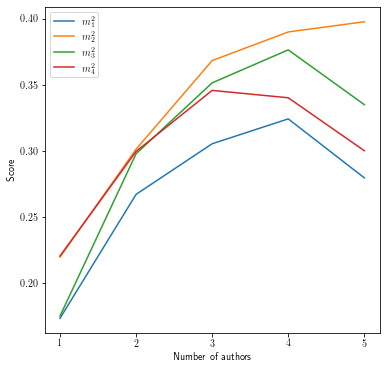

In [ ]:
# Loading saved outputs.
task2_m1_pred = np.load("task2_model1_style.npy")
task2_m2_pred = np.load("task2_model2_style.npy")
task2_m3_pred = np.load("task2_model3_style.npy")
task2_m4_pred = np.load("task2_model4_style.npy")


# To compute the ground truth
valid_directory = './dataset2/validation'
df_valid = create_dataframe(valid_directory)
task_2_gt = []
for i, row in df_valid.iterrows():
  task_2_gt += row["paragraph-authors"]


# Computing scores wrt to number of authors.
f1 = []
f1.append(compute_score_wrt_authors(2, task2_m1_pred, task_2_gt, df_valid))
f1.append(compute_score_wrt_authors(2, task2_m2_pred, task_2_gt, df_valid))
f1.append(compute_score_wrt_authors(2, task2_m3_pred, task_2_gt, df_valid))
f1.append(compute_score_wrt_authors(2, task2_m4_pred, task_2_gt, df_valid))

# Plotting scores.
plot_score_wrt_authors(f1, "task2_error_analysis")

## Task 3

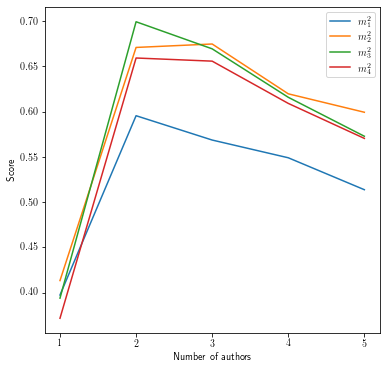

In [ ]:
# Loading saved outputs.
task3_m1_pred = np.load("task3_model1_style.npy")
task3_m2_pred = np.load("task3_model2_style.npy")
task3_m3_pred = np.load("task3_model3_style.npy")
task3_m4_pred = np.load("task3_model4_style.npy")


# To compute the ground truth
valid_directory = './dataset3/validation'
df_valid = create_dataframe(valid_directory)
task_3_gt = []
for i, row in df_valid.iterrows():
  task_3_gt += row["changes"]

# Computing scores wrt to number of authors.
f1 = []
f1.append(compute_score_wrt_authors(3, task3_m1_pred, task_3_gt, df_valid))
f1.append(compute_score_wrt_authors(3, task3_m2_pred, task_3_gt, df_valid))
f1.append(compute_score_wrt_authors(3, task3_m3_pred, task_3_gt, df_valid))
f1.append(compute_score_wrt_authors(3, task3_m4_pred, task_3_gt, df_valid))

# Plotting scores.
plot_score_wrt_authors(f1, "task3_error_analysis")